In [3]:
# from src.components.polarizationFock.light_source import SPDCSource
# from src.kernel.timeline import Timeline
# from src.components.photon import Photon
# from src.kernel.quantum_manager import POLARIZATION_FOCK_FORMALISM
# from src.utils.encoding import polarizationFock
from scipy import sparse as sp

from sequence.components.polarization_fock import light_source as seq_ls
from sequence.kernel.timeline import Timeline 
from sequence.kernel.quantum_manager import POLARIZATION_FOCK_FORMALISM

# import tensornetwork as tn
import numpy as np
from numpy.linalg import matrix_power
import qutip as qt
from numpy import kron, sqrt
from scipy import sparse as sp 
from scipy.linalg import expm, sqrtm
from math import factorial
from matplotlib import pyplot as plt
# plt.style.use('dark_background')

import copy
import re
import time


%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor import MatrixProductState as mps
from quimb.tensor import MatrixProductOperator as mpo
from quimb.tensor.tensor_1d import TensorNetwork1DOperator, TensorNetwork1DFlat, TensorNetwork1D, TensorNetwork1DVector
from quimb.tensor.tensor_arbgeom import get_coordinate_formatter, tensor_network_apply_op_vec
from quimb.tensor.tensor_core import rand_uuid, new_bond
from quimb.tensor.tensor_1d_compress import tensor_network_1d_compress, enforce_1d_like
from quimb.utils import oset
from quimb.tensor.tensor_core import oset_union

from autoray import do

from functools import lru_cache

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Support functions

In [4]:
# Vacuum state creation
def fill_fn(shape):
    arr = np.zeros(shape)
    idx = tuple([0]*(len(shape)))
    arr[idx] = 1
    return arr
def create_vacuum_state(num_modes, N, bond_dim = 2):
    return mps.from_fill_fn(
                fill_fn,
                L=num_modes,
                bond_dim=bond_dim,
                phys_dim=N,
                cyclic=False,
                tags="In"
            )

# Generating labels for reading state. 
def generate_labels(num_systems, N):
    dim = N**2
    labels = []
    state_labels = []
    for i in range(dim):
        state_labels.append(f"{i//N}H{i%N}V")
    # print("sates:", self.state_labels)
    for i in range(dim**num_systems):
        new_label = ""
        for j in range(num_systems-1, -1, -1):
            # print("appending to labels:", f"{self.state_labels[(i//self.dim**j)%self.dim]}_{chr(65+j)} ")
            new_label += f"{state_labels[(i//dim**j)%dim]}_{chr(65+j)} "
        labels.append(new_label[:-1])
    return labels

def read_quantum_state(TN_state, N, num_states = 4):
    dense_state = TN_state.to_dense()
    dense_state = np.reshape(dense_state.data, (-1, 1), order = 'C')
    dense_state = sp.csr_matrix(dense_state)
    dense_state.data = np.round(dense_state.data, 10)
    dense_state.eliminate_zeros()

    print_quantum_state(N, dense_state, num_states)

def print_quantum_state(N, dense_state, num_states = 4):
    labels = generate_labels(num_states,N)
    state = dense_state.nonzero()[0]
    print("Corresponding Basis terms:")
    for k in state: print(labels[k],"-",k,"-",dense_state[k].data)

def create_ladder_MPO(site, total_sites, N, tag="$Ladder$"):
    a = qt.destroy(N).full()
    a_dag = a.T
    TMSV_MPO = mpo.from_dense(a_dag, dims = N, sites = (site,), L=total_sites, tags=tag) 
    # return TMSV_MPO.fill_empty_sites(mode = "minimal")
    return TMSV_MPO

def create_MPO(site1, site2, total_sites, op, N, tag):
    MPO = mpo.from_dense(op, dims = N, sites = (site1,site2), L=total_sites, tags=tag)
    # new_arrays = []
    # for i in range(len(MPO.arrays)):
    #     if len(MPO.arrays[i].shape) == 3:
    #         new_arrays.append(MPO.arrays[i].reshape(-1, N, N))
    # # TMSV_MPO=mpo(TMSV_MPO.arrays)
    # MPO = mpo(new_arrays)
    # for i in MPO.arrays:
    #     print(i.shape)
    # print("Inside op")
    
    return MPO

# Beamsplitter transformation
def create_BS_MPO(site1, site2, theta, total_sites, N, tag = 'BS'): 

    a = qt.destroy(N).full()
    a_dag = a.T
    I = np.eye(N)
    
    # The V polarization would be transmitted unchanged. So, we only focus on the 
    # H polarized photons. Now, we have 2 modes of H polarized photons which need to be 
    # reflected. So, we create the unitaries for both individually and multiply them (not in this function.)

    hamiltonian_BS = -theta * ( kron(I, a_dag)@kron(a, I) - kron(I, a)@kron(a_dag, I) )
    unitary_BS = expm(hamiltonian_BS)

    BS_MPO = mpo.from_dense(unitary_BS, dims = N, sites = (site1,site2), L=total_sites, tags=tag)
    # BS_MPO = BS_MPO.fill_empty_sites(mode = "full")
    return BS_MPO

In [5]:

# This is the actual function that generates the POVM operator.
def create_threshold_POVM_OP_Dense(efficiency, outcome, N):
    a = qt.destroy(N).full()
    a_dag = a.T
    create0 = a_dag * sqrt(efficiency)
    destroy0 = a * sqrt(efficiency)
    series_elem_list = [((-1)**i) * matrix_power(create0, (i+1)) @ matrix_power(destroy0, (i+1)) / factorial(i+1) for i in range(N-1)] # (-1)^i * a_dag^(i+1) @ a^(i+1) / (i+1)! = (-1)^(i+2) * a_dag^(i+1) @ a^(i+1) / (i+1)! since goes from 0->n
    # print(series_elem_list[0])
    dense_op = sum(series_elem_list)

    if outcome == 0:
        dense_op = np.eye(dense_op.shape[0]) - dense_op
    # print(sqrtm(dense_op))
    return dense_op

@lru_cache(maxsize=20)
def factorial(x):
    n = 1
    for i in range(2, x+1):
        n *= i
    return n

@lru_cache(maxsize=20)
def comb(n, k):
    return factorial(n) / (factorial(k) * factorial(n - k))

@lru_cache(maxsize=20)
def projector(n, N):
    state = np.zeros(N)
    state[n] = 1
    return np.outer(state, state)

# Testing stuff out here. 
def create_PNR_POVM_OP_Dense(eff, outcome, N, debug = False):
    a_dag = qt.create(N).full()
    vacuum = np.zeros(N)
    vacuum[0] = 1

    @lru_cache(maxsize=20)
    def create_povm_list(eff, N):
        povms = []
        # m is the outcome here
        for m in range(N-1):
            op = 0
            for n in range(m, N):
                op += comb(n,m) * eff**m * (1-eff)**(n-m) * projector(n, N)
            povms.append(op)

        povms.append(np.eye(N) - sum(povms))
        return povms
    
    povms = create_povm_list(eff, N)
    if debug:
        return povms[outcome], povms
    return povms[outcome]



def generate_sqrt_POVM_MPO(sites, outcome, total_sites, efficiency, N, pnr = False, tag = "POVM"):
    if pnr:
        dense_op = sqrtm(create_PNR_POVM_OP_Dense(efficiency, outcome, N)).astype(np.complex128)
    else:
        dense_op = sqrtm(create_threshold_POVM_OP_Dense(efficiency, outcome, N)).astype(np.complex128)

    sqrt_POVM_MPOs = []
    for i in sites:
        sqrt_POVM_MPOs.append(mpo.from_dense(dense_op, dims = N, sites = (i,), L=total_sites, tags=tag))

    return sqrt_POVM_MPOs






### Create and apply operators

In [6]:
# TMSV operator
def old_create_TMSV_OP_Dense(N, mean_photon_num):

    a = qt.destroy(N).full()
    a_dag = a.T
    truncation = (N-1)      

    def generate_amp_list(mean_photon_num):
        amp_list = [(sqrt(mean_photon_num / (mean_photon_num + 1)) ** m) / sqrt(mean_photon_num + 1) for m in range(truncation)]
        amp_square_list = [amp ** 2 for amp in amp_list]
        amp_list.append(sqrt(1 - sum(amp_square_list)))
        return amp_list

    amp = generate_amp_list(mean_photon_num)

    op = np.complex128(0)
    for i in range(truncation+1):
        # TMSV is a 2 mode state (independent spatial modes). Hence, we take the tensor product of the two mode operators
        new_op = amp[i] * ( matrix_power(kron(a_dag, a_dag), i) ) / factorial(i)
        op += new_op

    return op

def create_TMSV_OP_Dense(N, mean_photon_num):
    a = qt.destroy(N).full()
    a_dag = a.T
    truncation = (N-1)   

    op = expm(1j * mean_photon_num * (kron(a_dag, a_dag) + kron(a, a)))

    return op


In [7]:
def light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress = True, contract = True):

    psi = vacuum.copy()
    psi.add_tag("L0")
    site_tags = psi.site_tags

    # Creating TMSV ops:
    TMSV_op_dense = create_TMSV_OP_Dense(N, mean_photon_num)

    TMSV_MPO_H = create_MPO(site1 = 0, site2 = 2, total_sites = num_modes, op = TMSV_op_dense, N = N, tag = r"$TMSV_H$")
    enforce_1d_like(TMSV_MPO_H, site_tags=site_tags, inplace=True)
    TMSV_MPO_H.add_tag("L1")

    TMSV_MPO_V = create_MPO(site1 = 5, site2 = 7, total_sites = num_modes, op = TMSV_op_dense, N = N, tag = r"$TMSV_V$")
    enforce_1d_like(TMSV_MPO_V, site_tags=site_tags, inplace=True)
    TMSV_MPO_V.add_tag("L1")

    # Creating PBS ops:
    U_PBS_H_Signal = create_BS_MPO(site1 = 2, site2 = 6, theta=np.pi/2, total_sites = num_modes, N = N, tag = r"$PBS_S$")
    enforce_1d_like(U_PBS_H_Signal, site_tags=site_tags, inplace=True)
    U_PBS_H_Signal.add_tag("L1")

    U_PBS_H_Idler = create_BS_MPO(site1 = 0, site2 = 4, theta=np.pi/2, total_sites = num_modes, N = N, tag = r"$PBS_I$")
    enforce_1d_like(U_PBS_H_Idler, site_tags=site_tags, inplace=True)
    U_PBS_H_Signal.add_tag("L1")

    # Create entangled state:
    psi = tensor_network_apply_op_vec(TMSV_MPO_H, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(TMSV_MPO_V, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(U_PBS_H_Idler, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(U_PBS_H_Signal, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    psi.normalize()

    # print("trace is:", np.linalg.norm(psi.to_dense()))

    for _ in range(4):
        psi.measure(0, remove = True, renorm = True, inplace = True)

    # Not used for TN implermentation. Used for validating impelmentation with dense version
    TMSV_state = psi.to_dense()
    TMSV_state = np.reshape(TMSV_state.data, (-1, 1), order = 'C')
    TMSV_state = sp.csr_matrix(TMSV_state)
    TMSV_state.data = np.round(TMSV_state.data, 10)
    TMSV_state.eliminate_zeros()

    return psi, TMSV_state

def new_ls(N, mean_photon_num, error_tolerance, compress = True, contract = True):
    trunc = N-1
    spdc = seq_ls.SPDCSource("", Timeline(formalism=POLARIZATION_FOCK_FORMALISM, truncation = trunc), mean_photon_num=mean_photon_num)
    dense_state = spdc._generate_tmsv_state(dm = False).toarray()

    psi = mps.from_dense(psi = dense_state, dims = N, tags = "ENT", cutoff = error_tolerance)
    return psi


# Generate truncation filter MPO 
# TODO: Make a function to renormalize a quantum state. How: find the projection of the quantum state onto itself and calculate the 
# probability. Next, take the square root of this number, divide it by the number nodes in the quantum state and multiply it with 
# all the states in the MPS. For density matrices, simply find the trace directly and do the same thing as the previous example except
# for not taking the square root.  The truncation filter would not work without the renormalization 
def create_truncation_filter_Dense(truncation):
    # This is only the projection operator. The states need to be normalized first. 
    N = truncation+1
    vacuum = np.zeros(N**2)
    vacuum[0] = 1

    a = qt.destroy(N).full()
    a_dag = a.T
    I = np.eye(N)

    # # debug
    # labels = generate_labels(1,N)

    op = 0
    for trunc in range(truncation, -1, -1):
        state = kron(matrix_power(a_dag, trunc), I) @ vacuum / sqrt(factorial(trunc) * factorial(0))
        op+=np.outer(state, state)
        coeffs = [trunc+1, 0]

        # # Debug
        # state_inds = state.nonzero()[0]
        # print("TMSV state:", [labels[i] for i in state_inds], "Val:", state[state_inds[0]])
        # print("coeffs", coeffs)

        for i in range(trunc):
            coeffs = [coeffs[0]-1, coeffs[1]+1]
            state = kron(a, a_dag) @ state / sqrt((coeffs[0]) * (coeffs[1]))
            op += np.outer(state, state)


            # # debug
            # state_inds = state.nonzero()[0]
            # print("TMSV state:", [labels[i] for i in state_inds], "Val:", state[state_inds[0]])
            # print("coeffs", coeffs)

    return op

# Ignore this. This is just for testing purposes.

# N = 3
# a = qt.destroy(N).full()
# a_dag = a.T
# truncation = (N-1)      

# def generate_amp_list(mean_photon_num):
#     amp_list = [(sqrt(mean_photon_num / (mean_photon_num + 1)) ** m) / sqrt(mean_photon_num + 1) for m in range(truncation)]
#     amp_square_list = [amp ** 2 for amp in amp_list]
#     amp_list.append(sqrt(1 - sum(amp_square_list)))
#     return amp_list

#     amp = generate_amp_list(mean_photon_num)

# generate_amp_list(0.5)
N = 5
trunc = N-1
chi = 0.5
error_tolerance = 1e-10

vac = np.zeros(N**2)
vac[0] = 1


op = create_TMSV_OP_Dense(N, chi)
dense_state = op @ vac

print(np.linalg.norm(dense_state))

labels = generate_labels(1,N)
state = dense_state.nonzero()[0]
print("Corresponding Basis terms:")
for k in state: print(labels[k],"-",k,"-",dense_state[k])



# print(state)

def new_create_TMSV_OP_Dense(N, mean_photon_num):
    a = qt.destroy(N).full()
    a_dag = a.T
    truncation = (N-1)   

    op = expm(1j * mean_photon_num * (kron(a_dag, a_dag) + kron(a, a)))

    return op

op = new_create_TMSV_OP_Dense(N, chi)
dense_state = op @ vac

print(np.linalg.norm(dense_state))

labels = generate_labels(1,N)
state = dense_state.nonzero()[0]
print("Corresponding Basis terms:")
for k in state: print(labels[k],"-",k,"-",dense_state[k])
    # amp_list = [(sqrt(mean_photon_num / (mean_photon_num + 1)) ** m) / sqrt(mean_photon_num + 1) for m in range(truncation)]
    # amp_square_list = [amp ** 2 for amp in amp_list]
    # amp_list.append(sqrt(1 - sum(amp_square_list)))
    # return amp_list


spdc = seq_ls.SPDCSource("", Timeline(formalism=POLARIZATION_FOCK_FORMALISM, truncation = trunc))
dense_state = spdc._generate_tmsv_state(dm = False)
# print("type:", type(dense_state.toarray()))

labels = generate_labels(2,N)
state = dense_state.nonzero()[0]
print("Corresponding Basis terms:")
for k in state: print(labels[k],"-",k,"-",dense_state[k].data)

psi = new_ls(N, chi, error_tolerance)

read_quantum_state(psi, N, num_states = 2)

num_modes = 8

vacuum = create_vacuum_state(num_modes=num_modes, N=N)
psi, TMSV_state = light_source(vacuum, N, chi, num_modes, error_tolerance)
# print(psi)
read_quantum_state(psi, N, num_states = 2)

Extend MPS (in this case, with itself since we have two sources). 

In [8]:
def extend_MPS(psi, psi_second = None):
    psi.permute_arrays('lrp')

    # This is supposed to be passed as the second MPS to extend the first MPS with. 
    if psi_second == None:
        psi_second = psi.copy()
    
    psi_num_modes = len(psi.site_tags)
    psi2_num_modes = len(psi_second.site_tags)

    psi_second.reindex({f"k{i}":f"k{i+psi_num_modes}" for i in range(psi2_num_modes)}, inplace = True)
    psi_second.retag({f"I{i}":f"I{i+psi_num_modes}" for i in range(psi2_num_modes)}, inplace = True)

    psi = psi.combine(psi_second)

    psi_last_tensor = psi.select_tensors(f"I{psi_num_modes-1}", which='any')[0]
    psi2_first_tensor = psi.select_tensors(f"I{psi_num_modes}", which='any')[0]

    new_bond(psi2_first_tensor, psi_last_tensor, axis1=0, axis2=1)

    # Simply find the tags for the input modes. 
    pattern = re.compile(r"I[0-9][0-9]*")
    tags = []
    for tag_list in [t.tags for t in psi]:
        for tag in tag_list:
            match = re.search(pattern, tag)
            if match:
                tags.append(match.string)
                break
            
    # print(tags)

    # for i,j in zip(psi.arrays, tags):
    #     print(i.shape, j, int(j[1:]))

    sorted_arrays = [array for array, _ in sorted( zip(psi.arrays, tags), key = lambda pair: int(pair[1][1:]) )]

    for array in sorted_arrays:
        print(array.shape)

    psi = mps(sorted_arrays)

    psi.add_tag("L1")
    psi.add_tag(r'$HH+VV$')

    return psi

# psi = extend_MPS(psi)

Perform the Bell state measurement

In [9]:
def bell_state_measurement(psi, N, site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress = True, contract = True):

    U_BS_H = create_BS_MPO(site1 = 2, site2 = 6, theta=np.pi/4, total_sites = num_modes, N = N, tag = r"$U_{BS_H}$")
    enforce_1d_like(U_BS_H, site_tags=site_tags, inplace=True)
    U_BS_H.add_tag("L2")

    U_BS_V = create_BS_MPO(site1 = 3, site2 = 7, theta=np.pi/4, total_sites = num_modes, N = N, tag = r"$U_{BS_V}$")
    enforce_1d_like(U_BS_V, site_tags=site_tags, inplace=True)
    U_BS_V.add_tag("L3")

    BSM_POVM_1_OPs = generate_sqrt_POVM_MPO(sites=(2,7), outcome = 1, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)
    BSM_POVM_1_OPs.extend(generate_sqrt_POVM_MPO(sites=(3,6), outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr))


    psi = tensor_network_apply_op_vec(U_BS_H, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(U_BS_V, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    for POVM_OP in BSM_POVM_1_OPs:
        POVM_OP.add_tag("L4")
        psi = tensor_network_apply_op_vec(POVM_OP, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    return psi

# psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)

In [10]:
def rotate_and_measure(psi, N, site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress = True, contract = True, draw = False):
    # idler_angles = [0]
    # angles = [np.pi/4]

    # We make this correction here since the rotator hamiltonian is 1/2(a_v b_h + a_h b_v), which does not show up in the bs unitary, whose function we are reusing to 
    # rotate the state.
    idler_angles = idler_angles/2
    signal_angles = signal_angles/2

    coincidence = []

    POVM_1_OPs = generate_sqrt_POVM_MPO(sites=(0,4), outcome = 1, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)
    POVM_0_OPs = generate_sqrt_POVM_MPO(sites=(1,5), outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)
    # POVM_0_OPs = generate_sqrt_POVM_MPO(sites=(0,4), outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)
    # enforce_1d_like(POVM_OP, site_tags=site_tags, inplace=True)

    meas_ops = POVM_1_OPs
    meas_ops.extend(POVM_0_OPs)

    for i, idler_angle in enumerate(idler_angles):
        coincidence_probs = []

        rotator_node_1 = create_BS_MPO(site1 = 0, site2 = 1, theta=idler_angle, total_sites = num_modes, N = N, tag = r"$Rotator_I$")
        enforce_1d_like(rotator_node_1, site_tags=site_tags, inplace=True)
        rotator_node_1.add_tag("L5")
        idler_rotated_psi = tensor_network_apply_op_vec(rotator_node_1, psi, compress=compress, contract = contract, cutoff = error_tolerance)


        for j, angle in enumerate(signal_angles):
            # print("idler:", i, "signal:", j)
        
            rotator_node_2 = create_BS_MPO(site1 = 4, site2 = 5, theta=angle, total_sites = num_modes, N = N, tag = r"$Rotator_S$")
            enforce_1d_like(rotator_node_2, site_tags=site_tags, inplace=True)
        
            # Rotate and measure:
            rotator_node_2.add_tag("L5")
            rho_rotated = tensor_network_apply_op_vec(rotator_node_2, idler_rotated_psi, compress=compress, contract = contract, cutoff = error_tolerance)

            # read_quantum_state(psi)
            # read_quantum_state(rho_rotated)

            for POVM_OP in meas_ops:
                POVM_OP.add_tag("L6")
                rho_rotated = tensor_network_apply_op_vec(POVM_OP, rho_rotated, compress=compress, contract = contract, cutoff = error_tolerance)
        
            if draw:
                rho_rotated.draw(color = [r'$HH+VV$', r'$U_{BS_H}$', r"$U_{BS_V}$", 'POVM', r'$Rotator_I$', r'$Rotator_S$'], title = "Polarization entanglement swapping MPS", fix = fix, show_inds = True, show_tags = False)
                # rho_rotated.draw_tn()
            coincidence_probs.append((rho_rotated.norm())**2)
        coincidence.append(coincidence_probs)
    
    return coincidence

# coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)

Plotting results

In [11]:
def plot_coincidences(coincidence, idler_angles, signal_angles, title = ''):
    visibilities = []
    for i in range(len(coincidence)):
        visibility = (max(coincidence[i]) - min(coincidence[i])) / (max(coincidence[i]) + min(coincidence[i]))
        visibilities.append(visibility)
        print(visibility, coincidence[i])

    plt.figure()
    plt.grid(True)
    for i in range(len(idler_angles)):
        # print(fringe_real[i])
        plt.plot(signal_angles, coincidence[i], label=r'Idler $\theta$={:.2f}$\pi$'.format(idler_angles[i]/np.pi))
    plt.title(title)
    plt.ylabel("Coincidence probability")
    plt.xlabel(r"$\alpha$ (rad)")    
    plt.legend()

    plt.figure()
    plt.grid(True)
    plt.plot(idler_angles, visibilities)
    plt.title("Visiblilities")
    plt.ylabel("Visibility")
    plt.xlabel(r"Idler $\theta$")    

Common parameters and functions

In [12]:
# params
trunc = 2
N = trunc+1
error_tolerance = 1e-15

mean_photon_num = (0.6)
efficiency = 0.9


num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
psi = extend_MPS(psi)

# only for drawing the TN. Not used otherwise
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}

idler_angles = np.linspace(0, np.pi, 15)
signal_angles = np.linspace(0, 2*np.pi, 40)

(3, 3)
(3, 6, 3)
(6, 3, 3)
(3, 1, 3)
(1, 3, 3)
(3, 6, 3)
(6, 3, 3)
(3, 3)


/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Performing measurements: 

Threshold detection

In [13]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

coincidence_Threshold = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)
print(time.time()-start)

18.72710633277893


PNR detection

In [14]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = True, compress=True, contract=True)

coincidence_PNR = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = True, compress=True, contract=True, draw = False)
print(time.time()-start)

24.318740844726562


Threshold results

0.936281254393959 [0.00020764929448700595, 0.00025024869066524744, 0.0003767103350218654, 0.0005830832176894581, 0.0008629737421083912, 0.0012078192500544183, 0.0016072449992337438, 0.002049481431208502, 0.0025218156310029063, 0.003011050193185624, 0.0035039442698333065, 0.003987615162761708, 0.00444988402116619, 0.004879555451782011, 0.005266627486212154, 0.00560243470026006, 0.005879732710520839, 0.006092736262749553, 0.0062371253169863404, 0.006310033767601344, 0.006310033767601375, 0.006237125316986279, 0.006092736262749564, 0.005879732710520826, 0.00560243470026006, 0.005266627486212096, 0.004879555451782009, 0.004449884021166184, 0.003987615162761694, 0.0035039442698333568, 0.0030110501931856575, 0.0025218156310029176, 0.002049481431208492, 0.0016072449992337373, 0.0012078192500544135, 0.0008629737421084053, 0.0005830832176894562, 0.00037671033502186565, 0.0002502486906652451, 0.00020764929448700592]
0.9327625366180136 [0.00029250292999474857, 0.0002208709523090859, 0.00023400204

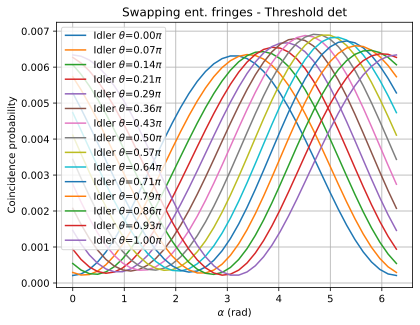

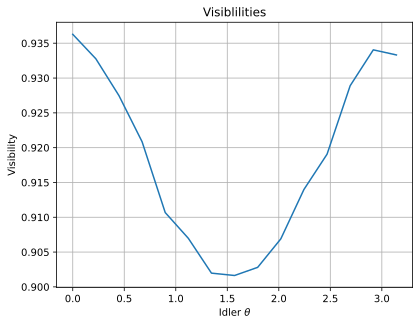

In [15]:
plot_coincidences(coincidence_Threshold, idler_angles, signal_angles, title = "Swapping ent. fringes - Threshold det")

PNR results

0.9773364636907993 [7.854815909596289e-06, 1.2248391581674113e-05, 2.5315327295910047e-05, 4.6717196281026826e-05, 7.589970137219439e-05, 0.00011210703101641647, 0.00015440143439474224, 0.0002016875086759008, 0.0002527405693742405, 0.0003062383690346169, 0.0003607953427469207, 0.0004149984935494721, 0.00046744398830808164, 0.0005167735162568487, 0.0005617094685335223, 0.0006010880275778994, 0.0006338893093953288, 0.0006592637780164646, 0.0006765542480326173, 0.0006853129053526338, 0.0006853129053526311, 0.0006765542480326133, 0.0006592637780164675, 0.000633889309395325, 0.000601088027577892, 0.0005617094685335253, 0.0005167735162568548, 0.00046744398830807714, 0.00041499849354946884, 0.00036079534274691767, 0.00030623836903461495, 0.000252740569374237, 0.00020168750867589834, 0.00015440143439473917, 0.00011210703101641435, 7.589970137219318e-05, 4.671719628102597e-05, 2.5315327295909322e-05, 1.2248391581673656e-05, 7.854815909596331e-06]
0.975468399568482 [1.6588896529570625e-05, 8.527

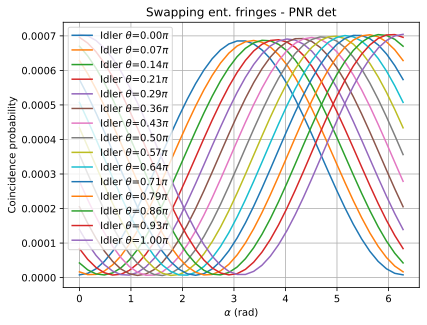

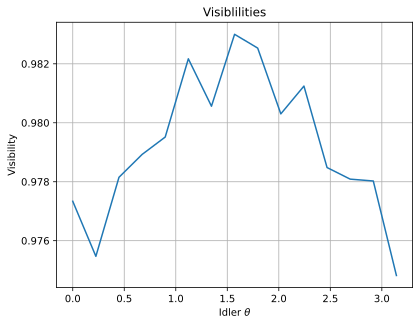

In [16]:
plot_coincidences(coincidence_PNR, idler_angles, signal_angles, title = "Swapping ent. fringes - PNR det")

Performing same simulatiosn for higher truncation

Common parameters and functions

In [10]:
# params
trunc = 3
N = trunc+1
error_tolerance = 1e-15

mean_photon_num = (0.6)
efficiency = 0.9


num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
psi = extend_MPS(psi)

# only for drawing the TN. Not used otherwise
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}

idler_angles = np.linspace(0, np.pi, 15)
signal_angles = np.linspace(0, 2*np.pi, 40)

/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Performing measurements: 

Threshold detection

In [11]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

coincidence_Threshold = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)
print(time.time()-start)

83.91316938400269


PNR detection

In [12]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = True, compress=True, contract=True)

coincidence_PNR = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = True, compress=True, contract=True, draw = False)
print(time.time()-start)

82.82326197624207


Threshold results

0.888112605903909 [0.0003574350742894173, 0.00040997300144098866, 0.0005649233837776098, 0.0008145238179103809, 0.001146539240059524, 0.001545239692862794, 0.001992609217864748, 0.0024696604098074747, 0.0029577198015210784, 0.0034395617998907815, 0.0039002948707473214, 0.004327939031365725, 0.004713672885445123, 0.005051765913065543, 0.005339242948918591, 0.005575349770768765, 0.005760900336722951, 0.005897588013989019, 0.0059873369397103245, 0.006031757867007337, 0.006031757867007347, 0.005987336939710258, 0.005897588013988921, 0.005760900336722939, 0.005575349770768725, 0.005339242948918549, 0.005051765913065604, 0.004713672885445109, 0.004327939031365707, 0.0039002948707473326, 0.0034395617998908036, 0.0029577198015210376, 0.0024696604098074807, 0.0019926092178647304, 0.0015452396928628093, 0.0011465392400595098, 0.0008145238179103762, 0.000564923383777607, 0.0004099724276247574, 0.00035743507428942137]
0.8850104105579719 [0.0004598191895765168, 0.0003777137940111233, 0.000399695955

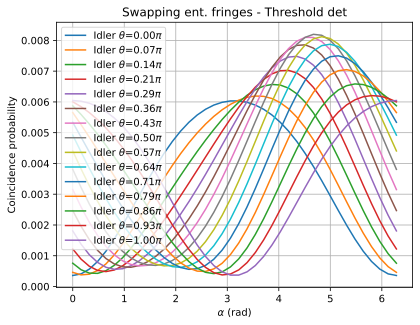

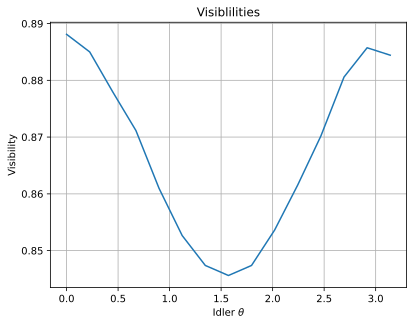

In [13]:
plot_coincidences(coincidence_Threshold, idler_angles, signal_angles, title = "Swapping ent. fringes - Threshold det")

PNR results

0.9746562013179682 [9.790273085513856e-06, 1.4673896794959355e-05, 2.9198196428110215e-05, 5.298706626478848e-05, 8.542436487664345e-05, 0.0001256699832681548, 0.0001726815810630311, 0.00022524158257244663, 0.00028198871136580014, 0.0003414532466152413, 0.0004020950880930912, 0.0004623436439587691, 0.0005206385082624563, 0.0005754698746395792, 0.0006254176395025647, 0.0006691881819778055, 0.0007056478680068009, 0.0007338524108728033, 0.0007530713277307322, 0.0007628068587292015, 0.000762806858729204, 0.0007530713277307267, 0.0007338524108727962, 0.0007056478680068003, 0.0006691881819778003, 0.0006254176395025586, 0.000575469874639576, 0.0005206385082624597, 0.00046234364395876586, 0.00040209508809308897, 0.00034145324661524046, 0.00028198871136580046, 0.00022524158257244628, 0.00017268158106303105, 0.00012566998326815602, 8.54243648766424e-05, 5.298706626478817e-05, 2.9198196428110404e-05, 1.4673874599657618e-05, 9.79027308551374e-06]
0.9730580350428641 [1.9376703881372522e-05, 1.04367

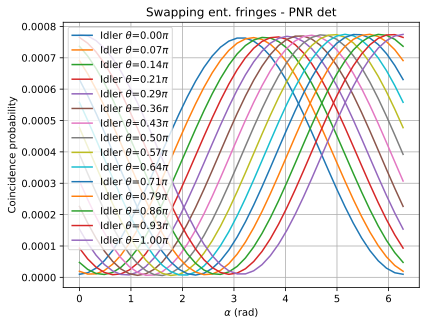

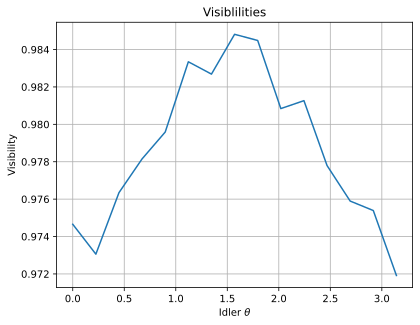

In [ ]:
plot_coincidences(coincidence_PNR, idler_angles, signal_angles, title = "Swapping ent. fringes - PNR det")

## Cascaded entanglement swaps

In [10]:
def bell_state_measurement(psi, N, site_tags, num_modes, efficiency, error_tolerance, modes = [(2,6),(3,7)], meas = {0:[3,6], 1:[2,7]}, pnr = False, compress = True, contract = True):

    
    for mode in modes:
        # Create the beamsplitter operator
        U_BS = create_BS_MPO(site1 = mode[0], site2 = mode[1], theta=np.pi/4, total_sites = num_modes, N = N, tag = r"$U_{BS}$")
        enforce_1d_like(U_BS, site_tags=site_tags, inplace=True)

        # Assign circuit level tag for drawing 
        U_BS.add_tag("L2")

        # Apply operator to MPS
        psi = tensor_network_apply_op_vec(U_BS, psi, compress=compress, contract = contract, cutoff = error_tolerance)

    for outcome, sites in meas.items(): 
        # Create the sqrt POVM operators
        POVM_OPs = generate_sqrt_POVM_MPO(sites=sites, outcome = outcome, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)

        # Assign circuit level tag for drawing and apply POVM operators to MPS
        for POVM_OP in POVM_OPs:
            POVM_OP.add_tag("L3")
            psi = tensor_network_apply_op_vec(POVM_OP, psi, compress=compress, contract = contract, cutoff = error_tolerance)
    
    return psi

# psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)

In [11]:
def rotate_and_measure(psi, N, site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, modes = [(0,1),(4,5)], meas = {0:[1,5], 1:[0,4]}, pnr = False, compress = True, contract = True, draw = False):
    # idler_angles = [0]
    # angles = [np.pi/4]

    # We make this correction here since the rotator hamiltonian is 1/2(a_v b_h + a_h b_v), which does not show up in the bs unitary, whose function we are reusing to 
    # rotate the state.
    idler_angles = idler_angles/2
    signal_angles = signal_angles/2

    coincidence = []


    
    POVM_0_OPs = generate_sqrt_POVM_MPO(sites=meas[0], outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)
    POVM_1_OPs = generate_sqrt_POVM_MPO(sites=meas[1], outcome = 1, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)
    
    # POVM_1_OPs = generate_sqrt_POVM_MPO(sites=(0,4), outcome = 1, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)
    # POVM_0_OPs = generate_sqrt_POVM_MPO(sites=(1,5), outcome = 0, total_sites=num_modes, efficiency=efficiency, N=N, pnr = pnr)

    meas_ops = POVM_1_OPs
    meas_ops.extend(POVM_0_OPs)

    for i, idler_angle in enumerate(idler_angles):
        coincidence_probs = []

        rotator_node_1 = create_BS_MPO(site1 = modes[0][0], site2 = modes[0][1], theta=idler_angle, total_sites = num_modes, N = N, tag = r"$Rotator_I$")
        enforce_1d_like(rotator_node_1, site_tags=site_tags, inplace=True)
        rotator_node_1.add_tag("L5")
        idler_rotated_psi = tensor_network_apply_op_vec(rotator_node_1, psi, compress=compress, contract = contract, cutoff = error_tolerance)


        for j, angle in enumerate(signal_angles):
            # print("idler:", i, "signal:", j)
        
            rotator_node_2 = create_BS_MPO(site1 = modes[1][0], site2 = modes[1][1], theta=angle, total_sites = num_modes, N = N, tag = r"$Rotator_S$")
            enforce_1d_like(rotator_node_2, site_tags=site_tags, inplace=True)
        
            # Rotate and measure:
            rotator_node_2.add_tag("L5")
            rho_rotated = tensor_network_apply_op_vec(rotator_node_2, idler_rotated_psi, compress=compress, contract = contract, cutoff = error_tolerance)

            # read_quantum_state(psi)
            # read_quantum_state(rho_rotated)

            for POVM_OP in meas_ops:
                POVM_OP.add_tag("L6")
                rho_rotated = tensor_network_apply_op_vec(POVM_OP, rho_rotated, compress=compress, contract = contract, cutoff = error_tolerance)
        
            if draw:
                rho_rotated.draw(color = [r'$HH+VV$', r'$U_{BS_H}$', r"$U_{BS_V}$", 'POVM', r'$Rotator_I$', r'$Rotator_S$'], title = "Polarization entanglement swapping MPS", fix = fix, show_inds = True, show_tags = False)
                # rho_rotated.draw_tn()
            coincidence_probs.append((rho_rotated.norm())**2)
        coincidence.append(coincidence_probs)
    
    return coincidence

# coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)

In [58]:
# params
trunc = 2
N = trunc+1
error_tolerance = 1e-5

mean_photon_num = (0.6)
efficiency = 0.9


num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
psi = extend_MPS(psi)

# only for drawing the TN. Not used otherwise
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}

idler_angles = np.linspace(0, np.pi, 10)#  15)
signal_angles = np.linspace(0, 2*np.pi, 10)# 40)

# print("second extension:")
# psi = extend_MPS(psi)
# psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)
psi

(3, 3)
(3, 6, 3)
(6, 3, 3)
(3, 1, 3)
(1, 3, 3)
(3, 6, 3)
(6, 3, 3)
(3, 3)


/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


MatrixProductState(tensors=8, indices=15, L=8, max_bond=6)

MatrixProductState([
    Tensor(shape=(3, 3), inds=('_261fa9AAcfz', 'k0'), tags=oset(['I0', 'L1', '$HH+VV$'])),
    Tensor(shape=(3, 6, 3), inds=('_261fa9AAcfz', '_261fa9AAcgA', 'k1'), tags=oset(['I1', 'L1', '$HH+VV$']), left_inds=('_261fa9AAcgA', 'k1')),
    Tensor(shape=(13, 11, 3), inds=('_261fa9AAcgC', '_261fa9AAcgD', 'k4'), tags=oset(['I4', 'L2', 'L1', '$HH+VV$']), left_inds=('_261fa9AAcgD', 'k4')),
    Tensor(shape=(11, 5, 3), inds=('_261fa9AAcgD', '_261fa9AAcgE', 'k5'), tags=oset(['I5', 'L2', 'L1', '$HH+VV$']), left_inds=('_261fa9AAcgE', 'k5')),
    Tensor(shape=(9, 13, 3), inds=('_261fa9AAcgB', '_261fa9AAcgC', 'k3'), tags=oset(['I3', 'L1', '$HH+VV$', 'L2', '$U_{BS}$', 'POVM', 'L3']), left_inds=('_261fa9AAcgC', 'k3')),
    Tensor(shape=(5, 2, 3), inds=('_261fa9AAcgE', '_261fa9AAcgF', 'k6'), tags=oset(['I6', 'L2', 'L1', '$HH+VV$', '$U_{BS}$', 'POVM', 'L3']), left_inds=('_261fa9AAcgF', 'k6')),
    Tensor(shape=(6, 9, 3), inds=('_261fa9AAcgA', '_261fa9AAcgB', 'k2'), tags=oset(['I2'

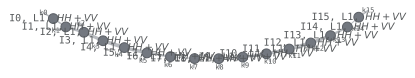

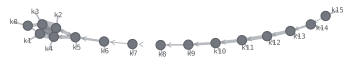

MatrixProductState([
    Tensor(shape=(5, 2, 3), inds=('_261fa9AAciO', '_261fa9AAciP', 'k6'), tags=oset(['I6', 'L1', '$HH+VV$']), left_inds=('_261fa9AAciP', 'k6')),
    Tensor(shape=(2, 1, 3), inds=('_261fa9AAciP', '_261fa9AAciQ', 'k7'), tags=oset(['I7', 'L1', '$HH+VV$']), left_inds=('_261fa9AAciQ', 'k7')),
    Tensor(shape=(1, 3, 3), inds=('_261fa9AAciQ', '_261fa9AAciR', 'k8'), tags=oset(['I8', 'L1', '$HH+VV$']), left_inds=('_261fa9AAciR', 'k8')),
    Tensor(shape=(3, 6, 3), inds=('_261fa9AAciR', '_261fa9AAciS', 'k9'), tags=oset(['I9', 'L1', '$HH+VV$']), left_inds=('_261fa9AAciS', 'k9')),
    Tensor(shape=(6, 9, 3), inds=('_261fa9AAciS', '_261fa9AAciT', 'k10'), tags=oset(['I10', 'L1', '$HH+VV$']), left_inds=('_261fa9AAciT', 'k10')),
    Tensor(shape=(9, 13, 3), inds=('_261fa9AAciT', '_261fa9AAciU', 'k11'), tags=oset(['I11', 'L1', '$HH+VV$']), left_inds=('_261fa9AAciU', 'k11')),
    Tensor(shape=(13, 11, 3), inds=('_261fa9AAciU', '_261fa9AAciV', 'k12'), tags=oset(['I12', 'L1', '$HH+VV$

SystemError: CPUDispatcher(<function svd_truncated_numba at 0x7f5d8235cd30>) returned a result with an exception set

In [59]:
start = time.time()
# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)
print(psi)

psi = extend_MPS(psi)

psi.draw()

# Something is not working here. Check the function and its application on the MPS. 
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, modes = [(4,8),(5,9)], meas = {0:[8,5], 1:[4,9]}, pnr = False, compress=True, contract=True)
psi.draw()
print(psi)
coincidence_Threshold = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, modes = [(0,1),(14,15)], meas = {0:[0,14], 1:[1,15]}, pnr = False, compress=True, contract=True, draw = False)
# print(time.time()-start)

## Performing the same simulations with lower detector efficiency

In [ ]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = (0.6)
num_modes = 8
efficiency = 0.5 # 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = True, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi, 15) # 15)
signal_angles = np.linspace(0, 2*np.pi, 40)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = True, compress=True, contract=True, draw = False)
print(time.time()-start)

/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


91.33076286315918


0.634391100202672 [0.00018075869836316801, 0.0001848271983711996, 0.00019692624230414338, 0.00021674328257176412, 0.00024376479545476759, 0.0002772909379632332, 0.00031645340061666415, 0.00036023789620343266, 0.000407510429286774, 0.00045704666609095167, 0.0005075636441029232, 0.0005577530001275287, 0.0006063148562069812, 0.0006519914857772099, 0.0006935998881251396, 0.0007300624274858779, 0.0007604347432428667, 0.0007839302083718363, 0.0007999403026675443, 0.0008080503730974549, 0.0008080503730974555, 0.0007999403026675405, 0.0007839302083718285, 0.0007604347432428684, 0.0007300624274858844, 0.000693599888125136, 0.0006519914857772054, 0.0006063148562069788, 0.0005577530001275241, 0.0005075636441029248, 0.00045704666609095004, 0.00040751042928677587, 0.0003602378962034291, 0.00031645340061666664, 0.0002772909379632355, 0.00024376479545477116, 0.00021674328257176293, 0.00019692624230414405, 0.00018482692558542734, 0.00018075869836316915]
0.633278449170395 [0.00018871129123387045, 0.000

Text(0.5, 0, 'Idler $\\theta$')

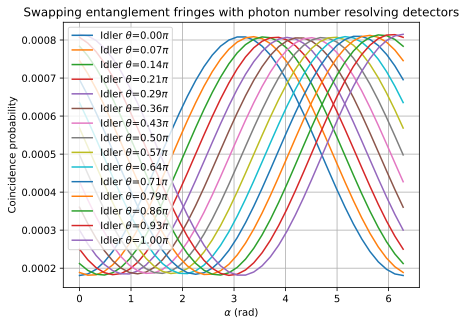

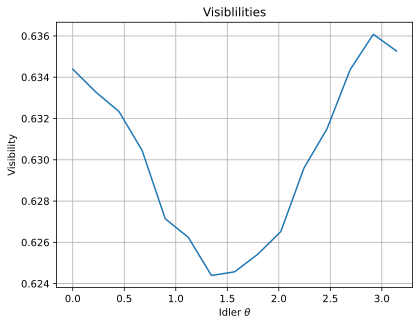

In [13]:
visibilities = []
for i in range(len(coincidence)):
    visibility = (max(coincidence[i]) - min(coincidence[i])) / (max(coincidence[i]) + min(coincidence[i]))
    visibilities.append(visibility)
    print(visibility, coincidence[i])

plt.figure()
plt.grid(True)
for i in range(len(idler_angles)):
    # print(fringe_real[i])
    plt.plot(signal_angles, coincidence[i], label=r'Idler $\theta$={:.2f}$\pi$'.format(idler_angles[i]/np.pi))
plt.title("Swapping entanglement fringes with photon number resolving detectors")
plt.ylabel("Coincidence probability")
plt.xlabel(r"$\alpha$ (rad)")    
plt.legend()

plt.figure()
plt.grid(True)
# for i in range(len(alpha_list)-1):
#     print(fringe_real[i])
plt.plot(idler_angles, visibilities)
plt.title("Visiblilities")
plt.ylabel("Visibility")
plt.xlabel(r"Idler $\theta$")    
# plt.legend()

This simulation is using the threshold detectors (original definition of POVM operator). 

In [14]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-20

mean_photon_num = 0.6
num_modes = 8
efficiency = 0.5

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
# psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

read_quantum_state(psi, N, num_states = 4)


# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

read_quantum_state(psi, N, num_states = 4)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi, 15) # 15)
signal_angles = np.linspace(0, 2*np.pi, 40)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)
print(time.time()-start)

Corresponding Basis terms:
0H0V_D 0H0V_C 0H0V_B 0H0V_A - 0 - [0.33112129+0.j]
0H0V_D 0H0V_C 0H1V_B 0H1V_A - 10 - [0.+0.18736198j]
0H0V_D 0H0V_C 0H2V_B 0H2V_A - 20 - [-0.26460474+0.j]
0H0V_D 0H0V_C 1H0V_B 1H0V_A - 30 - [0.+0.18736198j]
0H0V_D 0H0V_C 1H1V_B 1H1V_A - 40 - [-0.10601708+0.j]
0H0V_D 0H0V_C 2H0V_B 2H0V_A - 60 - [-0.26460474+0.j]
0H1V_D 0H1V_C 0H0V_B 0H0V_A - 810 - [0.+0.18736198j]
0H1V_D 0H1V_C 0H1V_B 0H1V_A - 820 - [-0.10601708+0.j]
0H1V_D 0H1V_C 0H2V_B 0H2V_A - 830 - [-0.-0.14972419j]
0H1V_D 0H1V_C 1H0V_B 1H0V_A - 840 - [-0.10601708+0.j]
0H1V_D 0H1V_C 1H1V_B 1H1V_A - 850 - [-0.-0.0599888j]
0H1V_D 0H1V_C 2H0V_B 2H0V_A - 870 - [-0.-0.14972419j]
0H2V_D 0H2V_C 0H0V_B 0H0V_A - 1620 - [-0.26460474+0.j]
0H2V_D 0H2V_C 0H1V_B 0H1V_A - 1630 - [-0.-0.14972419j]
0H2V_D 0H2V_C 0H2V_B 0H2V_A - 1640 - [0.21145022-0.j]
0H2V_D 0H2V_C 1H0V_B 1H0V_A - 1650 - [-0.-0.14972419j]
0H2V_D 0H2V_C 1H1V_B 1H1V_A - 1660 - [0.08472008-0.j]
0H2V_D 0H2V_C 2H0V_B 2H0V_A - 1680 - [0.21145022-0.j]
1H0V_D 1H0

0.8235598463979527 [6.8844862131526995e-06, 7.2758396265781815e-06, 8.441727849129548e-06, 1.0357644347367135e-05, 1.2982797189083608e-05, 1.6260256758682255e-05, 2.0117291782646612e-05, 2.4466002136694812e-05, 2.9204360796217694e-05, 3.421776501956543e-05, 3.9381168909902105e-05, 4.456182812816508e-05, 4.96226365072387e-05, 5.442597858703712e-05, 5.883796725342489e-05, 6.273288740994649e-05, 6.599763012997153e-05, 6.853588117859177e-05, 7.027182583234065e-05, 7.115314946789921e-05, 7.115314946789889e-05, 7.027182583234086e-05, 6.853588117859149e-05, 6.599763012997143e-05, 6.273288740994615e-05, 5.8837967253424456e-05, 5.442597858703647e-05, 4.962263650723853e-05, 4.456182812816498e-05, 3.938116890990225e-05, 3.421776501956539e-05, 2.9204360796217637e-05, 2.4466002136694812e-05, 2.0117291782646642e-05, 1.6260256758682238e-05, 1.298279718908368e-05, 1.0357644347367145e-05, 8.441727849129503e-06, 7.275839626578107e-06, 6.884486213152729e-06]
0.8028146366008012 [7.700706214380577e-06, 7.8

Text(0.5, 0, 'Idler $\\theta$')

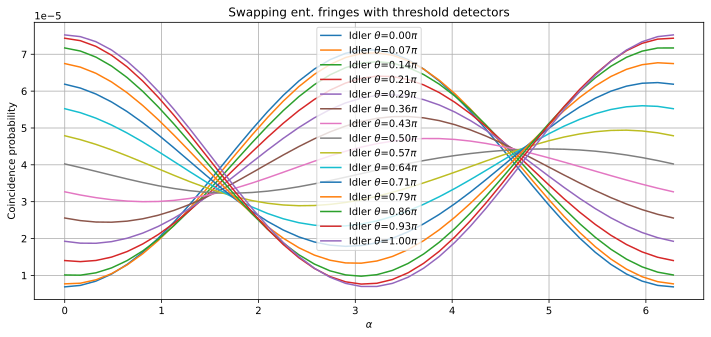

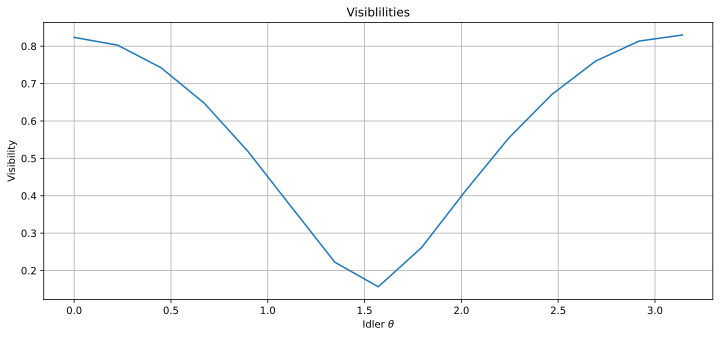

Bad pipe message: %s [b'\xf6v', b'\xe9\x11o\xedol\xa2\xa9\x88\xe6\x15\xd2\xfaq\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0']
Bad pipe message: %s [b'\n\xc0\x0b\xc0\x0c\xc0\r\xc0']
Bad pipe message: %s [b'\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15']
Bad pip

In [15]:
visibilities = []
for i in range(len(coincidence)):
    visibility = (max(coincidence[i]) - min(coincidence[i])) / (max(coincidence[i]) + min(coincidence[i]))
    visibilities.append(visibility)
    print(visibility, coincidence[i])

plt.figure(figsize = (12,5))
plt.grid(True)
for i in range(len(idler_angles)):
    # print(fringe_real[i])
    plt.plot(signal_angles, coincidence[i], label=r'Idler $\theta$={:.2f}$\pi$'.format(idler_angles[i]/np.pi))
plt.title("Swapping ent. fringes with threshold detectors")
plt.ylabel("Coincidence probability")
plt.xlabel(r"$\alpha$")    
plt.legend()

plt.figure(figsize = (12,5))
plt.grid(True)
# for i in range(len(alpha_list)-1):
#     print(fringe_real[i])
plt.plot(idler_angles, visibilities)
plt.title("Visiblilities")
plt.ylabel("Visibility")
plt.xlabel(r"Idler $\theta$")    
# plt.legend()

In [22]:
# params
trunc = 3
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = np.sqrt(0.06)
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi/2, 10)
signal_angles = np.linspace(0, np.pi, 20)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress=True, contract=True, draw = False)
print(time.time()-start)

# plt.grid()
# for i in range(len(idler_angles)):
#     plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()





SystemError: CPUDispatcher(<function qr_stabilized_numba at 0x7fc87f9c4280>) returned a result with an exception set

0.7652262665052498 [4.686633243017588e-05, 5.448428491821786e-05, 7.673565784999554e-05, 0.00011178620446153169, 0.0001565295977651937, 0.00020663513518744838, 0.0002567975603158837, 0.00030125525089446444, 0.0003345481594874876, 0.00035238048051215774, 0.0003523804193376696, 0.00033454710173179614, 0.00030125190301760155, 0.00025679253888325615, 0.00020663130122960745, 0.00015652966527179558, 0.00011179012322290021, 7.6740663159089e-05, 5.4487558702594295e-05, 4.686733662012374e-05]
0.7788363827956937 [5.534784548482949e-05, 4.386667589192364e-05, 4.80819312821034e-05, 6.811468853498462e-05, 0.00010248742078421705, 0.00014799372851830261, 0.0001998253887124572, 0.0002520373362911063, 0.00029832737290870986, 0.0003329916700661508, 0.0003518369858130958, 0.00035282312730839684, 0.0003362832036581137, 0.0003046979450709991, 0.00026213205040144554, 0.0002135222097506962, 0.0001640093802368149, 0.00011844018081062942, 8.106197346982771e-05, 5.535021887200222e-05]
0.8140451469047519 [8.0043

/tmp/ipykernel_791070/3421890716.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


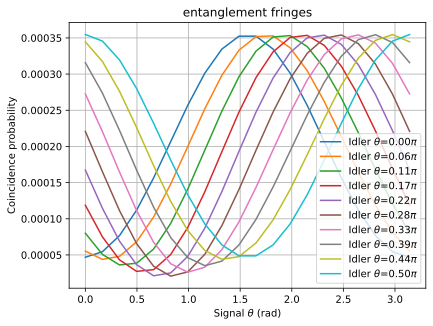

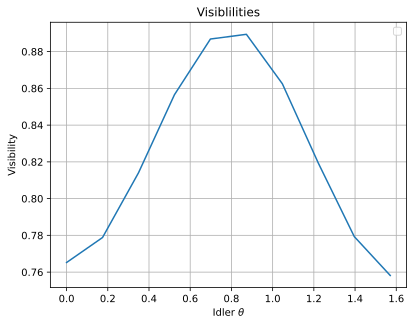

In [15]:
visibilities = []
for i in range(len(coincidence)):
    visibility = (max(coincidence[i]) - min(coincidence[i])) / (max(coincidence[i]) + min(coincidence[i]))
    visibilities.append(visibility)
    print(visibility, coincidence[i])

plt.figure()
plt.grid(True)
for i in range(len(idler_angles)):
    # print(fringe_real[i])
    plt.plot(signal_angles, coincidence[i], label=r'Idler $\theta$={:.2f}$\pi$'.format(idler_angles[i]/np.pi))
plt.title("entanglement fringes")
plt.ylabel("Coincidence probability")
plt.xlabel(r"Signal $\theta$ (rad)")    
plt.legend()

plt.figure()
plt.grid(True)
# for i in range(len(alpha_list)-1):
#     print(fringe_real[i])
plt.plot(idler_angles, visibilities)
plt.title("Visiblilities")
plt.ylabel("Visibility")
plt.xlabel(r"Idler $\theta$")    
plt.legend()

237.84472703933716


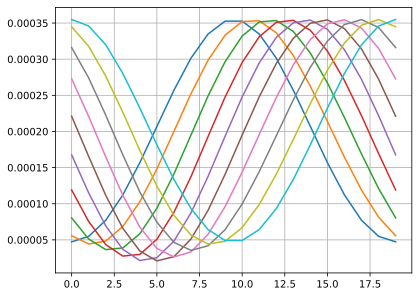

In [9]:
# params
trunc = 4
N = trunc+1
# mean_photon_num = 0.02
# num_modes = 8
# efficiency = 0.9
error_tolerance = 1e-15

mean_photon_num = np.sqrt(0.06)
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15

# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# Include emission from other lightsource
start = time.time()
psi = extend_MPS(psi)

error_tolerance = 1e-15

# Perform Bell state measurement
psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

# psi.draw()

# Rotate polarizers and perform measurements
# idler_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
idler_angles = np.linspace(0, np.pi/2, 10)
signal_angles = np.linspace(0, np.pi, 20)
# signal_angles = [0]
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}
coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, compress=True, contract=True, draw = False)
print(time.time()-start)

plt.grid()
for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

### Statevector version

In [9]:
from numpy import kron
import scipy.sparse as sp

a = qt.destroy(N).full()
a = sp.csr_matrix(a)
a_dag = a.T

# Support functions:
def create_op(left_indices, op, right_indices):
    if left_indices == 0:
        return sp.kron(op, sp.eye(N**right_indices))
    elif right_indices == 0:
        return sp.kron(sp.eye(N**left_indices), op)
    else:    
        out_op = sp.kron(sp.eye(N**left_indices), op)
        return sp.kron(out_op, sp.eye(N**right_indices))
def _find_mat_exp(mat):
    ans = sp.eye(mat.shape[0])
    intermediate = 1
    for i in range(1, 50+1):
        intermediate *= mat/i
        intermediate.eliminate_zeros()
        ans += intermediate
    return ans 
def read_quantum_state_sparse(sparse_state, N):
    temp_sparse_state = sp.csr_matrix(sparse_state)
    temp_sparse_state.data = np.round(temp_sparse_state.data, 10)
    temp_sparse_state.eliminate_zeros()
    labels = generate_labels(4,N)
    state = temp_sparse_state.nonzero()[0]
    print(f"{len(state)} non-zero elements Corresponding Basis terms:")
    for k in state: print(labels[k],"-",k,"-",temp_sparse_state[k].data)

def extend_state_sparse(state):
    return sp.kron(state, state)
# TMSV_state_dense = extend_state_sparse(TMSV_state)

def bell_state_measurement_sparse(TMSV_state_dense, N, efficiency):
    # BSM BS implementation
    BSM_H_0_Mode_op = create_op(2, a_dag, 5)
    print(BSM_H_0_Mode_op.shape, len(BSM_H_0_Mode_op.nonzero()[0]), len(BSM_H_0_Mode_op.nonzero()[1]))
    BSM_V_0_Mode_op = create_op(3, a_dag, 4)
    BSM_H_1_Mode_op = create_op(6, a_dag, 1)
    BSM_V_1_Mode_op = create_op(7, a_dag, 0)
    hamiltonian_BS_H = -np.pi/4 * ( BSM_H_0_Mode_op.T@BSM_H_1_Mode_op - BSM_H_0_Mode_op@BSM_H_1_Mode_op.T )
    unitary_BS_H = _find_mat_exp(hamiltonian_BS_H)

    hamiltonian_BS_V = -np.pi/4 * ( BSM_V_0_Mode_op.T@BSM_V_1_Mode_op - BSM_V_0_Mode_op@BSM_V_1_Mode_op.T )
    unitary_BS_V = _find_mat_exp(hamiltonian_BS_V)


    # BSM povm implementation
    povm_op_1 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 1, N))
    povm_op_0 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 0, N))

    BSM_povm = create_op(2, povm_op_1, 0)
    BSM_povm = create_op(0, sp.kron(BSM_povm, povm_op_0), 2)
    BSM_povm = sp.kron(BSM_povm, sp.kron(povm_op_0, povm_op_1))

    # print(unitary_BS_V.shape, unitary_BS_H.shape, TMSV_state_dense.shape)
    
    post_BS_State = unitary_BS_V @ unitary_BS_H @ TMSV_state_dense
    post_BSM_State = BSM_povm @ post_BS_State

    return post_BSM_State
# post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)

def rotate_and_measure_sparse(post_BSM_State, N, efficiency):
    # Polarization rotators mode operators
    rotator_H_0_Mode_op = create_op(0, a_dag, 7)
    rotator_V_0_Mode_op = create_op(1, a_dag, 6)
    rotator_H_1_Mode_op = create_op(4, a_dag, 3)
    rotator_V_1_Mode_op = create_op(5, a_dag, 2)

    povm_op_1 = sp.csr_matrix(create_POVM_OP_Dense(efficiency, 1, N))

    # polarization analysis detector POVMs
    pol_analyzer_povm = create_op(0, povm_op_1, 3)
    pol_analyzer_povm = create_op(0, sp.kron(pol_analyzer_povm, povm_op_1), 3)

    # Applying rotations and measuring

    signal_angles = np.linspace(0, np.pi, 10)
    # idler_angles = np.linspace(0, np.pi, 20)
    idler_angles = [0]
    coincidence = []

    for i, idler_angle in enumerate(idler_angles):
        coincidence_probs = []

        hamiltonian_rotator_1 = -idler_angle * ( rotator_H_1_Mode_op.T@rotator_V_1_Mode_op - rotator_H_1_Mode_op@rotator_V_1_Mode_op.T )
        unitary_rotator_1 = _find_mat_exp(hamiltonian_rotator_1)
        post_idler_detection_state = unitary_rotator_1 @ post_BSM_State
        # post_idler_detection_state = post_BSM_State
        
        for j, angle in enumerate(signal_angles):
            # print("idler:", i, "signal:", j)
        
            hamiltonian_rotator_0 = -angle * ( rotator_H_0_Mode_op.T@rotator_V_0_Mode_op - rotator_H_0_Mode_op@rotator_V_0_Mode_op.T )
            unitary_rotator_0 = _find_mat_exp(hamiltonian_rotator_0)
            post_rotations_state = unitary_rotator_0 @ post_idler_detection_state

            measured_state = pol_analyzer_povm @ post_rotations_state

            coincidence_probs.append(sp.linalg.norm(measured_state)**2)
        coincidence.append(coincidence_probs)
    return coincidence, idler_angles
# coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)

done with extension
(65536, 65536) 49152 49152
done with bell_state_measurement_sparse
done with rotate_and_measure_sparse


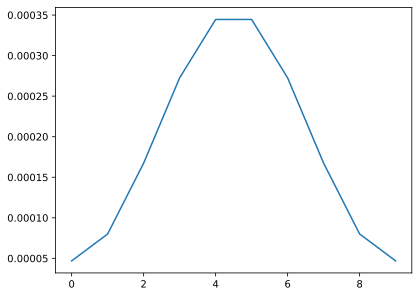

In [10]:
# read_quantum_state_sparse(TMSV_state, N)

TMSV_state_dense = extend_state_sparse(TMSV_state)
print("done with extension")
# read_quantum_state_sparse(TMSV_state_dense, N)
post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)
print("done with bell_state_measurement_sparse")

# state_indices, _ = post_BSM_State.nonzero()
# num_photons = 2
# for n in state_indices:
#     for i in range(num_photons):
#         H = (n // (N**(2*i+1))) % N
#         V = (n // (N**(2*i+0))) % N
#         # print("n:", n, "H:", H, "V:", V, "i", i, "Val:", entangled_state[n,0])
#         if H+V > trunc:
#             # print("deleted:", n)
#             post_BSM_State[n,0] = 0  

# read_quantum_state_sparse(post_BSM_State, N) 

# read_quantum_state_sparse(post_BSM_State, N)
coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)
print("done with rotate_and_measure_sparse")

for i in range(len(idler_angles)):
    plt.plot((coincidence[i]), label = f"{i}")
# plt.legend()

Performance comparisons

In [11]:
# params
mean_photon_num = 0.2
num_modes = 8
efficiency = 0.9
initial_error_tolerance = 1e-15
truncations = [1,2,3,4,5,6]
error_tolerances = [1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
TN_data = []
sparse_data = []

num_iter = 5

for error_tolerance in error_tolerances:
    TN_data_error_tol = []
    for trunc in truncations:
        N = trunc+1
        vacuum = create_vacuum_state(num_modes=num_modes, N=N)
        
        time_taken = 0
        for iter in range(num_iter):
            psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, initial_error_tolerance)
            # TN data:
            start = time.time()
            psi = extend_MPS(psi)
            psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance)
            idler_angles = [0]
            coincidence = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles)
            time_taken += time.time() - start
        
        TN_data_error_tol.append(time_taken/num_iter)
        
        print("truncation:", trunc)
    print("error:", error_tolerance)
    TN_data.append(TN_data_error_tol)

truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-05
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-06
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-07
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-08
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-09
truncation: 1
truncation: 2
truncation: 3
truncation: 4
truncation: 5
truncation: 6
error: 1e-10


In [12]:
corrected_TN_data = []
for i in TN_data[:6]:
    corrected_TN_data.append([2*j for j in i])
corrected_TN_data

[[0.37795286178588866,
  0.49544363021850585,
  1.160251522064209,
  1.8715259552001953,
  3.6817642211914063,
  6.2446390151977536],
 [0.37921533584594724,
  0.5582192420959473,
  2.207474422454834,
  4.248854732513427,
  5.60923137664795,
  8.473978233337402],
 [0.3784365653991699,
  0.5515198707580566,
  2.335206699371338,
  5.527664089202881,
  8.341994571685792,
  12.478046989440918],
 [0.37646961212158203,
  0.7961133003234864,
  6.180577373504638,
  9.55179042816162,
  14.224153995513916,
  19.299321365356445],
 [0.39735660552978513,
  0.9513609886169434,
  5.009572887420655,
  10.528872203826904,
  15.55453701019287,
  22.058192825317384],
 [0.38264780044555663,
  0.9167355537414551,
  8.105130481719971,
  14.237593746185302,
  23.17667531967163,
  33.90475454330444]]

[0.37795286178588866, 0.49544363021850585, 1.160251522064209, 1.8715259552001953, 3.6817642211914063, 6.2446390151977536] 1e-05
[0.37921533584594724, 0.5582192420959473, 2.207474422454834, 4.248854732513427, 5.60923137664795, 8.473978233337402] 1e-06
[0.3784365653991699, 0.5515198707580566, 2.335206699371338, 5.527664089202881, 8.341994571685792, 12.478046989440918] 1e-07
[0.37646961212158203, 0.7961133003234864, 6.180577373504638, 9.55179042816162, 14.224153995513916, 19.299321365356445] 1e-08
[0.39735660552978513, 0.9513609886169434, 5.009572887420655, 10.528872203826904, 15.55453701019287, 22.058192825317384] 1e-09
[0.38264780044555663, 0.9167355537414551, 8.105130481719971, 14.237593746185302, 23.17667531967163, 33.90475454330444] 1e-10


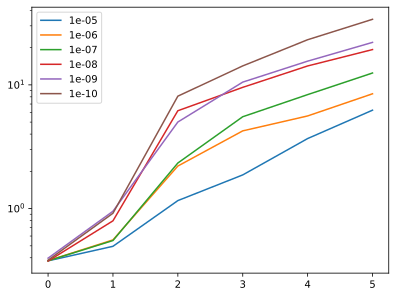

In [13]:

for i in range(len(corrected_TN_data)):
    plt.plot(corrected_TN_data[i], label=f"{error_tolerances[i]}")
    print(corrected_TN_data[i], error_tolerances[i])
plt.legend()
plt.yscale('log')


In [ ]:
sparse_data = []
num_iter = 2
for trunc in truncations:

    a = qt.destroy(trunc+1).full()
    a = sp.csr_matrix(a)
    a_dag = a.T
    
    time_taken = 0
    for iter in range(num_iter):
        N = trunc+1
        vacuum = create_vacuum_state(num_modes=num_modes, N=N)
        
        psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, initial_error_tolerance)

        start = time.time()
        # Sparse matrix data:
        TMSV_state_dense = extend_state_sparse(TMSV_state)
        post_BSM_State = bell_state_measurement_sparse(TMSV_state_dense, N, efficiency)
        coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency)

        time_taken += time.time() - start
        print("iter:", iter)

    sparse_data.append(time_taken/num_iter)
    print(trunc)



(256, 256) 128 128
iter: 0
(256, 256) 128 128
iter: 1
1
(6561, 6561) 4374 4374
iter: 0
(6561, 6561) 4374 4374
iter: 1
2
(65536, 65536) 49152 49152
iter: 0
(65536, 65536) 49152 49152
iter: 1
3
(390625, 390625) 312500 312500
iter: 0
(390625, 390625) 312500 312500
iter: 1
4
(1679616, 1679616) 1399680 1399680


{1e-05: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-06: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-07: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-08: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-09: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736], 1e-10: [0.09655718803405762, 0.7302299022674561, 14.933477115631103, 46.71982793807983, 84.28161706924439, 70.73001379966736]}


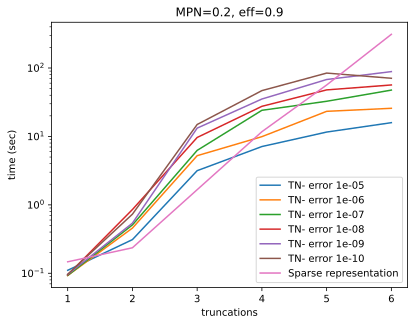

In [ ]:
import json
for i in range(len(corrected_TN_data)):
    plt.plot(truncations, corrected_TN_data[i], label=f"TN- error {error_tolerances[i]}")
plt.plot(truncations, sparse_data, label="Sparse representation")
plt.legend()
plt.yscale('log')
plt.ylabel("time (sec)")
plt.xlabel("truncations")
plt.title("MPN=0.2, eff=0.9")

time_dict_TN = {err:times for err in error_tolerances for times in corrected_TN_data}
time_sparse = sparse_data
truncations = truncations
print(time_dict_TN)

json_file = open("projects/swapping/timing_analysis/TN_data_mpn02.json", "a+")
json.dump(time_dict_TN, json_file)
sparse_data_file = open("projects/swapping/timing_analysis/sparse_data_mpn02.txt", "a+")
np.savetxt(sparse_data_file, time_sparse)
# truncations_file = open("projects/swapping/timing_analysis/truncations.txt", "a+")
# np.savetxt(truncations_file, truncations)

In [ ]:
print()

### Create density matrix

In [ ]:
psi_H = psi.H
# psi_H.retag_({'I{}': 'Out{}'})
psi_H.site_ind_id = 'b{}'
psi_H.combine(psi)
rho = (psi_H | psi)

for i in range(rho.L):
    rho ^= f"I{i}"
    
rho = rho.fuse_multibonds()   
rho = mpo(rho.arrays)
rho.compress(cutoff = 1e-5)

rho